For predicting the taxi Fare in new york using XGBoost, Linear Regression and Tensor FLow

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [2]:

taxi_feature = pd.read_csv(r'C:\Exercise\TaxiFare\train.csv',index_col=0,nrows=3000000)
taxi_feature_test = pd.read_csv(r'C:\Exercise\TaxiFare\test.csv')
print("Train")
print(taxi_feature.shape)

taxi_feature.dropna(axis=0,how='any')
taxi_feature_test.dropna(axis=0,how='any')

print(taxi_feature_test.shape)


Train
(3000000, 7)


(9914, 7)


1) Check for data inconsistency(null or missing value and outliers). We clearly find outliers by seeing the describe function. latitude lies between -90 to +90 and longitude lies between -180 and +180
2) Dropping out -ve fare values which is not possible

In [3]:
print("\nTrain data stats\n")
print(taxi_feature.describe())
#print(taxi_feature.isnull().sum())
print("\nTest data stats\n")
print(taxi_feature_test.describe())
print(taxi_feature_test.head())


Train data stats



        fare_amount  pickup_longitude  pickup_latitude  dropoff_longitude  \
count  3.000000e+06      3.000000e+06     3.000000e+06       2.999977e+06   
mean   1.134246e+01     -7.250894e+01     3.992033e+01      -7.250740e+01   
std    9.828907e+00      1.320223e+01     8.644440e+00       1.308827e+01   
min   -6.200000e+01     -3.426609e+03    -3.488080e+03      -3.408430e+03   
25%    6.000000e+00     -7.399207e+01     4.073492e+01      -7.399139e+01   
50%    8.500000e+00     -7.398181e+01     4.075263e+01      -7.398016e+01   
75%    1.250000e+01     -7.396710e+01     4.076712e+01      -7.396367e+01   
max    1.273310e+03      3.439426e+03     2.912465e+03       3.457622e+03   

       dropoff_latitude  passenger_count  
count      2.999977e+06     3.000000e+06  
mean       3.991728e+01     1.684528e+00  
std        9.984419e+00     1.329084e+00  
min       -3.488080e+03     0.000000e+00  
25%        4.073402e+01     1.000000e+00  
50%        4.075315e+01     1.000000e+00  
75%  

In [4]:
def outliers(taxi_feature):#finding out outliers in latitude and longitude values
    
    taxi_feature.drop(taxi_feature[(taxi_feature.pickup_longitude < -180) & (taxi_feature.pickup_longitude > 180)].index,inplace=True)
    
    taxi_feature.drop(taxi_feature[(taxi_feature.dropoff_longitude > 180) & (taxi_feature.dropoff_longitude < -180)].index,inplace=True)
    
    taxi_feature.drop(taxi_feature[(taxi_feature.pickup_latitude > 90) & (taxi_feature.pickup_latitude < -90)].index,inplace=True)
    
    taxi_feature.drop(taxi_feature[(taxi_feature.dropoff_latitude > 90) & (taxi_feature.dropoff_latitude < -90)].index,inplace=True)
    
    if 'fare_amount' in taxi_feature:
        taxi_feature.drop(taxi_feature[taxi_feature.fare_amount < 0].index,inplace=True)
#New york city Latitude and longitude coordinates are: 40.730610, -73.935242.
#Boundary of New York City is (-75, -73, 40, 42)

    taxi_feature.drop(taxi_feature[(taxi_feature.pickup_longitude > 42) & (taxi_feature.pickup_longitude < 40)].index,inplace=True)
    
    taxi_feature.drop(taxi_feature[(taxi_feature.dropoff_longitude < 40) & (taxi_feature.dropoff_longitude > 42)].index,inplace=True)
    
    taxi_feature.drop(taxi_feature[(taxi_feature.pickup_latitude < -75) & (taxi_feature.pickup_latitude > -73)].index,inplace=True)
    
    taxi_feature.drop(taxi_feature[(taxi_feature.dropoff_latitude < -75) & (taxi_feature.dropoff_latitude > -73)].index,inplace=True)

    return taxi_feature

In [5]:
#call outliers function for traing and test dataset
taxi_feature = outliers(taxi_feature)
print("\nTrain data stats\n")
#print(taxi_feature.describe())
print(taxi_feature.shape)
print("\nTest data stats\n")
taxi_feature_test = outliers(taxi_feature_test)
#print(taxi_feature_test.describe())
print(taxi_feature_test.shape)


Train data stats

(2999876, 7)

Test data stats



(9914, 7)



Split records for month day time format based on column 'pickup datetime'

In [6]:
#split pickupdatetime
taxi_feature['pickup_datetime'] = pd.to_datetime(taxi_feature['pickup_datetime'],infer_datetime_format=True)
taxi_feature_test['pickup_datetime'] = pd.to_datetime(taxi_feature_test['pickup_datetime'], infer_datetime_format=True)# important


In [7]:
#function to split datetime column into year/month/day/hour and day of week
def split_date(df):
    taxi_feature['year'] = df.pickup_datetime.dt.year
    taxi_feature['month'] = df.pickup_datetime.dt.month
    taxi_feature['day'] = df.pickup_datetime.dt.day
    taxi_feature['hour'] = df.pickup_datetime.dt.hour
    taxi_feature['day_of_week'] = df.pickup_datetime.dt.dayofweek    
    return taxi_feature

In [8]:
taxi_feature = split_date(taxi_feature)
#drop pickup datetime column
taxi_feature.drop('pickup_datetime',axis=1,inplace=True)
print(taxi_feature.head())


                               fare_amount  pickup_longitude  pickup_latitude  \
key                                                                             
2009-06-15 17:26:21.0000001            4.5        -73.844311        40.721319   
2010-01-05 16:52:16.0000002           16.9        -74.016048        40.711303   
2011-08-18 00:35:00.00000049           5.7        -73.982738        40.761270   
2012-04-21 04:30:42.0000001            7.7        -73.987130        40.733143   
2010-03-09 07:51:00.000000135          5.3        -73.968095        40.768008   

                               dropoff_longitude  dropoff_latitude  \
key                                                                  
2009-06-15 17:26:21.0000001           -73.841610         40.712278   
2010-01-05 16:52:16.0000002           -73.979268         40.782004   
2011-08-18 00:35:00.00000049          -73.991242         40.750562   
2012-04-21 04:30:42.0000001           -73.991567         40.758092   
2010-03-09 0

plot variation of rush hour  or weekday or no of passenger count which affects the price of taxi in New York

In [9]:
#function to split datetime column into year/month/day/hour and day of week
def split_date_test(df):
    taxi_feature_test['year'] = df.pickup_datetime.dt.year
    taxi_feature_test['month'] = df.pickup_datetime.dt.month
    taxi_feature_test['day'] = df.pickup_datetime.dt.day
    taxi_feature_test['hour'] = df.pickup_datetime.dt.hour
    taxi_feature_test['day_of_week'] = df.pickup_datetime.dt.dayofweek    
    return taxi_feature_test


In [10]:
taxi_feature_test = split_date_test(taxi_feature_test)
#drop pickup datetime column
taxi_feature_test.drop('pickup_datetime',axis=1,inplace=True)
print(taxi_feature_test.head())

                           key  pickup_longitude  pickup_latitude  \
0  2015-01-27 13:08:24.0000002        -73.973320        40.763805   
1  2015-01-27 13:08:24.0000003        -73.986862        40.719383   
2  2011-10-08 11:53:44.0000002        -73.982524        40.751260   
3  2012-12-01 21:12:12.0000002        -73.981160        40.767807   
4  2012-12-01 21:12:12.0000003        -73.966046        40.789775   

   dropoff_longitude  dropoff_latitude  passenger_count  year  month  day  \
0         -73.981430         40.743835                1  2015      1   27   
1         -73.998886         40.739201                1  2015      1   27   
2         -73.979654         40.746139                1  2011     10    8   
3         -73.990448         40.751635                1  2012     12    1   
4         -73.988565         40.744427                1  2012     12    1   

   hour  day_of_week  
0    13            1  
1    13            1  
2    11            5  
3    21            5  
4    21

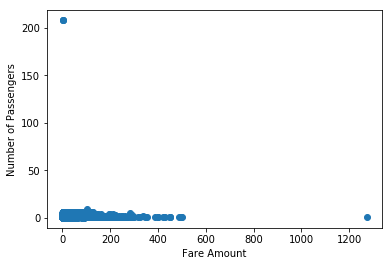

In [13]:

#plot for taxi fare price compared to rush hours/weekday 
%matplotlib inline 
plt.figure()
plt.scatter(taxi_feature['fare_amount'],taxi_feature['passenger_count'])
plt.xlabel("Fare Amount")
plt.ylabel("Number of Passengers")
plt.show()


We observe in the plot that the fare is highest for a single commuter. As the number of passengers increases in the cab, the fare goes down

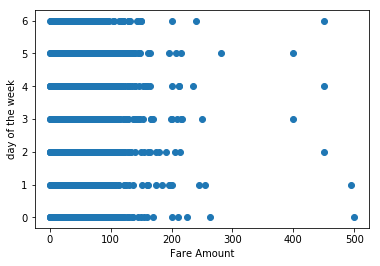

In [12]:
#plot for taxi fare price compared to day of the week 
plt.figure()
plt.scatter(taxi_feature['fare_amount'],taxi_feature['day_of_week'])
plt.ylabel("day of the week")
plt.xlabel("Fare Amount")
plt.show()

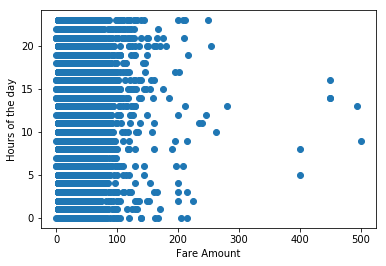

In [13]:
#plot for comparing hour of the day and fare amount
plt.figure()
plt.scatter(taxi_feature['fare_amount'],taxi_feature['hour'])
plt.ylabel("Hours of the day")
plt.xlabel("Fare Amount")
plt.show()

Use of haversine distance to calculate distance between 2 locations using latitude and longitude

Haversine
formula:
--- a = sin²(Δφ/2) + cos φ1 ⋅ cos φ2 ⋅ sin²(Δλ/2)
--- c = 2 ⋅ atan2( √a, √(1−a) )
--- d = R ⋅ c
where	φ is latitude, λ is longitude, R is earth’s radius (mean radius = 6,371km);
note that angles need to be in radians to pass to trig functions!

In [11]:
def haversine(df):
    R = 6371
    delta_lat = np.radians(df['dropoff_latitude'] - df['pickup_latitude'])
    delta_long = np.radians(df['dropoff_longitude'] - df['pickup_longitude'])
    lat2 = np.radians(df['dropoff_latitude'])
    lat1 = np.radians(df['pickup_latitude'])
    a = (np.sin(delta_lat/2.0)**2) + (np.sin(delta_long/2.0)**2) * np.cos(lat2) * np.cos(lat1)
    c = 2 * (np.arctan2(np.sqrt(a),np.sqrt(1 - a))) 
    df['distance'] = R * c
    return df

In [12]:
taxi_feature = haversine(taxi_feature)
#print(taxi_feature.head())
taxi_feature_test = haversine(taxi_feature_test)
#print(taxi_feature_test.head())

In [13]:
taxi_feature['dropoff_longitude'].replace(np.nan,0,inplace=True)
taxi_feature['dropoff_latitude'].replace(np.nan,0,inplace=True)
taxi_feature['distance'].replace(np.nan,0,inplace=True)
taxi_feature.dropna(axis=0,how='any')
print(taxi_feature.isnull().sum())
print("\n")
#test data
taxi_feature_test['dropoff_longitude'].replace(np.nan,0,inplace=True)
taxi_feature_test['dropoff_latitude'].replace(np.nan,0,inplace=True)
taxi_feature_test['distance'].replace(np.nan,0,inplace=True)
taxi_feature_test.dropna(axis=0,how='any')
print(taxi_feature_test.isnull().sum())

fare_amount          0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
year                 0
month                0
day                  0
hour                 0
day_of_week          0
distance             0
dtype: int64


key                  0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
year                 0
month                0
day                  0
hour                 0
day_of_week          0
distance             0
dtype: int64


In [15]:
#taxi_feature= taxi_feature.reset_index()
taxi_feature_x = taxi_feature.iloc[:,1:]
taxi_feature_y = taxi_feature.iloc[:,0:1]
print("y: \n" + str(taxi_feature_y.head()))
print("x: \n" + str(taxi_feature_x.head()))

y: 
                               fare_amount
key                                       
2009-06-15 17:26:21.0000001            4.5
2010-01-05 16:52:16.0000002           16.9
2011-08-18 00:35:00.00000049           5.7
2012-04-21 04:30:42.0000001            7.7
2010-03-09 07:51:00.000000135          5.3
x: 
                               pickup_longitude  pickup_latitude  \
key                                                                
2009-06-15 17:26:21.0000001          -73.844311        40.721319   
2010-01-05 16:52:16.0000002          -74.016048        40.711303   
2011-08-18 00:35:00.00000049         -73.982738        40.761270   
2012-04-21 04:30:42.0000001          -73.987130        40.733143   
2010-03-09 07:51:00.000000135        -73.968095        40.768008   

                               dropoff_longitude  dropoff_latitude  \
key                                                                  
2009-06-15 17:26:21.0000001           -73.841610         40.712278   
2010

In [16]:
#split dataset
x_train, x_test,y_train, y_test = \
    train_test_split(taxi_feature_x,taxi_feature_y,random_state=0,test_size=0.2)

#linear regression
lm_same = LinearRegression()
lm_model_same = lm_same.fit(x_train,y_train)
lm_y_same = lm_model_same.predict(x_test)
print("coefficient :" + str(lm_model_same.coef_))
print("MSE:\n" + str(mse(y_test,lm_y_same)))
print("R2_score" + str(r2_score(y_test,lm_y_same)))


coefficient :[[ 1.42711686e-03 -2.29321453e-03  2.52903958e-03 -5.73052886e-04
   8.87354472e-02  6.33372767e-01  1.11568164e-01  2.71345650e-03
  -2.65684951e-02  2.71989582e-03  6.04612032e-04]]
MSE:
94.87153888006443
R2_score0.01590381927254625


In [26]:
rf = RandomForestRegressor(random_state=30)
rf.fit(x_train, y_train)
rf_predict = rf.predict(x_test)
print("MSE:\n" + str(mse(y_test,rf_predict)))

C:\Users\Apurva\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


MSE:
19.50236026689157


In [28]:
#final prediction
#print(taxi_feature_test.head())

#print(taxi_feature_test.keys())
y_pred_final = rf.predict(taxi_feature_test.iloc[:,1:])

submission = pd.DataFrame(
    {'key': taxi_feature_test['key'],'fare_amount': y_pred_final},
    columns = ['key', 'fare_amount'])
#print(submission)
submission.to_csv('C:\Exercise\TaxiFare\submission.csv', index = False)

In [68]:
#implement xgboost
xgb_model = XGBRegressor(learning_rate=0.1,subsample=0.6,max_delta_step=5,booster='gbtree')
xgb_model.fit(x_train,y_train)
xgb_predict = xgb_model.predict(x_test)
print("MSE of XGB :\n" + str(mse(y_test,xgb_predict)))

MSE of XGB :
19.883395148725015


Run and get XGBoost Submission!

In [69]:
submission = pd.DataFrame(
    {'key': taxi_feature_test['key'],'fare_amount': xgb_model.predict(taxi_feature_test.iloc[:,1:])},
    columns = ['key', 'fare_amount'])
#print(submission)
submission.to_csv('C:\Exercise\TaxiFare\submission.csv', index = False)

In [76]:
#implement tensorflow

from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.optimizers import Adam, Adagrad,  Adadelta

model = Sequential()
model.add(Dense(64, activation='relu', input_dim=x_train.shape[1]))
model.add(Dense(16, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1))

adam = Adam(lr=0.0005)
model.compile(loss='mse', optimizer=adam, metrics=['mae'])

In [103]:
history = model.fit(x=x_train, y=y_train, epochs=1, batch_size=1024,  
                    verbose=1, shuffle=True)

Epoch 1/1000
   1024/2399900 [..............................] - ETA: 5:10 - loss: 42.7834 - mean_absolute_error: 2.5012

  11264/2399900 [..............................] - ETA: 38s - loss: 26.6559 - mean_absolute_error: 2.3297 

  20480/2399900 [..............................] - ETA: 27s - loss: 24.1942 - mean_absolute_error: 2.3166

  29696/2399900 [..............................] - ETA: 23s - loss: 23.1286 - mean_absolute_error: 2.2719

  43008/2399900 [..............................] - ETA: 18s - loss: 22.7458 - mean_absolute_error: 2.2688

 796672/2399900 [========>.....................] - ETA: 9s - loss: 27.4079 - mean_absolute_error: 2.2840

 806912/2399900 [=========>....................] - ETA: 9s - loss: 27.3483 - mean_absolute_error: 2.2834

 817152/2399900 [=========>....................] - ETA: 9s - loss: 27.2834 - mean_absolute_error: 2.2826

 827392/2399900 [=========>....................] - ETA: 9s - loss: 27.2096 - mean_absolute_error: 2.2813

 837632/2399900 [=========>....................] - ETA: 8s - loss: 27.2603 - mean_absolute_error: 2.2812

 846848/2399900 [=========>....................] - ETA: 8s - loss: 27.3303 - mean_absolute_error: 2.2820

  47104/2399900 [..............................] - ETA: 24s - loss: 25.5099 - mean_absolute_error: 2.2892

  55296/2399900 [..............................] - ETA: 23s - loss: 25.7249 - mean_absolute_error: 2.3013

  64512/2399900 [..............................] - ETA: 21s - loss: 25.6373 - mean_absolute_error: 2.3078

  74752/2399900 [..............................] - ETA: 20s - loss: 25.8325 - mean_absolute_error: 2.3002

In [102]:
val_prediction = model.predict(x_test, verbose=1)
print("MSE:\n" + str(mse(y_test,np.hstack(val_prediction))))


prediction = model.predict(taxi_feature_test.iloc[:,1:], verbose=1)

    32/599976 [..............................] - ETA: 3:25

  2144/599976 [..............................] - ETA: 17s 

  4384/599976 [..............................] - ETA: 15s

  5792/599976 [..............................] - ETA: 16s

  6880/599976 [..............................] - ETA: 18s

  8160/599976 [..............................] - ETA: 19s

  9504/599976 [..............................] - ETA: 19s

 10144/599976 [..............................] - ETA: 22s

 10176/599976 [..............................] - ETA: 25s

 10592/599976 [..............................] - ETA: 27s

 11136/599976 [..............................] - ETA: 29s

 12320/599976 [..............................] - ETA: 28s

 14080/599976 [..............................] - ETA: 27s

 15744/599976 [..............................] - ETA: 26s

 17472/599976 [..............................] - ETA: 25s

 18944/599976 [..............................] - ETA: 24s

 20704/599976 [>.............................] - ETA: 23s

 22496/599976 [>.............................] - ETA: 23s

 24160/599976 [>.............................] - ETA: 22s

 25600/599976 [>.............................] - ETA: 22s

 27104/599976 [>.............................] - ETA: 22s

 28896/599976 [>.............................] - ETA: 21s

 30560/599976 [>.............................] - ETA: 21s

 31808/599976 [>.............................] - ETA: 21s

 33568/599976 [>.............................] - ETA: 21s

 35392/599976 [>.............................] - ETA: 20s

 37248/599976 [>.............................] - ETA: 20s

 38656/599976 [>.............................] - ETA: 20s

 40320/599976 [=>............................] - ETA: 20s

 42080/599976 [=>............................] - ETA: 20s

 43776/599976 [=>............................] - ETA: 19s

 45184/599976 [=>............................] - ETA: 19s

 46944/599976 [=>............................] - ETA: 19s

 48608/599976 [=>............................] - ETA: 19s

 50336/599976 [=>............................] - ETA: 19s

 51712/599976 [=>............................] - ETA: 19s

 53536/599976 [=>............................] - ETA: 19s

 55296/599976 [=>............................] - ETA: 18s

 56864/599976 [=>............................] - ETA: 18s

 58272/599976 [=>............................] - ETA: 18s

 60032/599976 [==>...........................] - ETA: 18s

 61792/599976 [==>...........................] - ETA: 18s

 63552/599976 [==>...........................] - ETA: 18s

 64928/599976 [==>...........................] - ETA: 18s



 66752/599976 [==>...........................] - ETA: 18s

 68160/599976 [==>...........................] - ETA: 18s

 69728/599976 [==>...........................] - ETA: 18s

 71232/599976 [==>...........................] - ETA: 18s

 72960/599976 [==>...........................] - ETA: 17s

 74752/599976 [==>...........................] - ETA: 17s

 76032/599976 [==>...........................] - ETA: 17s

 77216/599976 [==>...........................] - ETA: 17s

 78880/599976 [==>...........................] - ETA: 17s

 80640/599976 [===>..........................] - ETA: 17s

 82496/599976 [===>..........................] - ETA: 17s

 84000/599976 [===>..........................] - ETA: 17s

 85664/599976 [===>..........................] - ETA: 17s

 87552/599976 [===>..........................] - ETA: 17s

 89216/599976 [===>..........................] - ETA: 17s

 90528/599976 [===>..........................] - ETA: 17s

 92128/599976 [===>..........................] - ETA: 17s

 93952/599976 [===>..........................] - ETA: 16s

 95776/599976 [===>..........................] - ETA: 16s

 97280/599976 [===>..........................] - ETA: 16s

 98944/599976 [===>..........................] - ETA: 16s

100736/599976 [====>.........................] - ETA: 16s

102560/599976 [====>.........................] - ETA: 16s

104032/599976 [====>.........................] - ETA: 16s

105664/599976 [====>.........................] - ETA: 16s

107488/599976 [====>.........................] - ETA: 16s

109312/599976 [====>.........................] - ETA: 16s



110368/599976 [====>.........................] - ETA: 16s

111680/599976 [====>.........................] - ETA: 16s

113344/599976 [====>.........................] - ETA: 16s

115136/599976 [====>.........................] - ETA: 16s

116704/599976 [====>.........................] - ETA: 15s

118336/599976 [====>.........................] - ETA: 15s

120192/599976 [=====>........................] - ETA: 15s

121792/599976 [=====>........................] - ETA: 15s

123232/599976 [=====>........................] - ETA: 15s

124768/599976 [=====>........................] - ETA: 15s

126496/599976 [=====>........................] - ETA: 15s

128320/599976 [=====>........................] - ETA: 15s

129920/599976 [=====>........................] - ETA: 15s

131488/599976 [=====>........................] - ETA: 15s

133376/599976 [=====>........................] - ETA: 15s

135168/599976 [=====>........................] - ETA: 15s

136640/599976 [=====>........................] - ETA: 15s

138240/599976 [=====>........................] - ETA: 15s

139968/599976 [=====>........................] - ETA: 15s

140928/599976 [======>.......................] - ETA: 15s

142528/599976 [======>.......................] - ETA: 14s

144096/599976 [======>.......................] - ETA: 14s

145856/599976 [======>.......................] - ETA: 14s

147648/599976 [======>.......................] - ETA: 14s

149216/599976 [======>.......................] - ETA: 14s

150848/599976 [======>.......................] - ETA: 14s

152704/599976 [======>.......................] - ETA: 14s

154304/599976 [======>.......................] - ETA: 14s

155808/599976 [======>.......................] - ETA: 14s

157088/599976 [======>.......................] - ETA: 14s

158848/599976 [======>.......................] - ETA: 14s

160672/599976 [=======>......................] - ETA: 14s

162304/599976 [=======>......................] - ETA: 14s

163872/599976 [=======>......................] - ETA: 14s

165632/599976 [=======>......................] - ETA: 14s

167392/599976 [=======>......................] - ETA: 14s

168992/599976 [=======>......................] - ETA: 13s

170432/599976 [=======>......................] - ETA: 13s

172128/599976 [=======>......................] - ETA: 13s

173760/599976 [=======>......................] - ETA: 13s

175648/599976 [=======>......................] - ETA: 13s

178144/599976 [=======>......................] - ETA: 13s

180672/599976 [========>.....................] - ETA: 13s

183360/599976 [========>.....................] - ETA: 13s

186080/599976 [========>.....................] - ETA: 13s

188832/599976 [========>.....................] - ETA: 12s

191232/599976 [========>.....................] - ETA: 12s



193760/599976 [========>.....................] - ETA: 12s

195872/599976 [========>.....................] - ETA: 12s

198624/599976 [========>.....................] - ETA: 12s

201312/599976 [=========>....................] - ETA: 12s

204032/599976 [=========>....................] - ETA: 12s

206752/599976 [=========>....................] - ETA: 11s

209440/599976 [=========>....................] - ETA: 11s

212096/599976 [=========>....................] - ETA: 11s

214816/599976 [=========>....................] - ETA: 11s

217440/599976 [=========>....................] - ETA: 11s

220128/599976 [==========>...................] - ETA: 11s

222784/599976 [==========>...................] - ETA: 11s

224128/599976 [==========>...................] - ETA: 11s

226880/599976 [==========>...................] - ETA: 11s

229440/599976 [==========>...................] - ETA: 10s

232128/599976 [==========>...................] - ETA: 10s

234848/599976 [==========>...................] - ETA: 10s

237568/599976 [==========>...................] - ETA: 10s

240224/599976 [===========>..................] - ETA: 10s

242528/599976 [===========>..................] - ETA: 10s

245280/599976 [===========>..................] - ETA: 10s

248000/599976 [===========>..................] - ETA: 10s

250624/599976 [===========>..................] - ETA: 9s 

253344/599976 [===========>..................] - ETA: 9s

256064/599976 [===========>..................] - ETA: 9s

258752/599976 [===========>..................] - ETA: 9s

261440/599976 [============>.................] - ETA: 9s

264128/599976 [============>.................] - ETA: 9s

266816/599976 [============>.................] - ETA: 9s

269504/599976 [============>.................] - ETA: 9s

272256/599976 [============>.................] - ETA: 9s

274720/599976 [============>.................] - ETA: 9s

277376/599976 [============>.................] - ETA: 8s

280000/599976 [=============>................] - ETA: 8s

282688/599976 [=============>................] - ETA: 8s

285472/599976 [=============>................] - ETA: 8s

288160/599976 [=============>................] - ETA: 8s

290912/599976 [=============>................] - ETA: 8s

293568/599976 [=============>................] - ETA: 8s

295872/599976 [=============>................] - ETA: 8s

298560/599976 [=============>................] - ETA: 8s

301184/599976 [==============>...............] - ETA: 8s

303872/599976 [==============>...............] - ETA: 7s

306592/599976 [==============>...............] - ETA: 7s

309248/599976 [==============>...............] - ETA: 7s

311904/599976 [==============>...............] - ETA: 7s

314592/599976 [==============>...............] - ETA: 7s

317280/599976 [==============>...............] - ETA: 7s

319936/599976 [==============>...............] - ETA: 7s

322656/599976 [===============>..............] - ETA: 7s

325376/599976 [===============>..............] - ETA: 7s

327808/599976 [===============>..............] - ETA: 7s

329472/599976 [===============>..............] - ETA: 7s

331968/599976 [===============>..............] - ETA: 7s

333856/599976 [===============>..............] - ETA: 7s

336544/599976 [===============>..............] - ETA: 6s

339264/599976 [===============>..............] - ETA: 6s

342016/599976 [================>.............] - ETA: 6s

344480/599976 [================>.............] - ETA: 6s

346944/599976 [================>.............] - ETA: 6s

349632/599976 [================>.............] - ETA: 6s

352352/599976 [================>.............] - ETA: 6s

355040/599976 [================>.............] - ETA: 6s

357728/599976 [================>.............] - ETA: 6s

360448/599976 [=================>............] - ETA: 6s

363168/599976 [=================>............] - ETA: 6s

365856/599976 [=================>............] - ETA: 6s

368512/599976 [=================>............] - ETA: 5s

371136/599976 [=================>............] - ETA: 5s

373920/599976 [=================>............] - ETA: 5s

376512/599976 [=================>............] - ETA: 5s

379072/599976 [=================>............] - ETA: 5s

381632/599976 [==================>...........] - ETA: 5s

384256/599976 [==================>...........] - ETA: 5s

386912/599976 [==================>...........] - ETA: 5s

389632/599976 [==================>...........] - ETA: 5s

392352/599976 [==================>...........] - ETA: 5s

395008/599976 [==================>...........] - ETA: 5s

397216/599976 [==================>...........] - ETA: 5s

399232/599976 [==================>...........] - ETA: 5s

401600/599976 [===================>..........] - ETA: 4s

404288/599976 [===================>..........] - ETA: 4s

407008/599976 [===================>..........] - ETA: 4s

409728/599976 [===================>..........] - ETA: 4s

412416/599976 [===================>..........] - ETA: 4s

415104/599976 [===================>..........] - ETA: 4s

417760/599976 [===================>..........] - ETA: 4s

420448/599976 [====================>.........] - ETA: 4s

423136/599976 [====================>.........] - ETA: 4s

425728/599976 [====================>.........] - ETA: 4s

428192/599976 [====================>.........] - ETA: 4s

430880/599976 [====================>.........] - ETA: 4s

432320/599976 [====================>.........] - ETA: 4s

435072/599976 [====================>.........] - ETA: 4s

437760/599976 [====================>.........] - ETA: 4s

440352/599976 [=====================>........] - ETA: 3s

442848/599976 [=====================>........] - ETA: 3s

445440/599976 [=====================>........] - ETA: 3s

447552/599976 [=====================>........] - ETA: 3s

450208/599976 [=====================>........] - ETA: 3s

452864/599976 [=====================>........] - ETA: 3s

455584/599976 [=====================>........] - ETA: 3s

458272/599976 [=====================>........] - ETA: 3s

460992/599976 [======================>.......] - ETA: 3s

463712/599976 [======================>.......] - ETA: 3s

466400/599976 [======================>.......] - ETA: 3s

469056/599976 [======================>.......] - ETA: 3s

471744/599976 [======================>.......] - ETA: 3s

474432/599976 [======================>.......] - ETA: 3s

477152/599976 [======================>.......] - ETA: 2s

479616/599976 [======================>.......] - ETA: 2s

482336/599976 [=======================>......] - ETA: 2s

484832/599976 [=======================>......] - ETA: 2s

487552/599976 [=======================>......] - ETA: 2s

490272/599976 [=======================>......] - ETA: 2s

493024/599976 [=======================>......] - ETA: 2s

495680/599976 [=======================>......] - ETA: 2s

498016/599976 [=======================>......] - ETA: 2s

500512/599976 [========================>.....] - ETA: 2s

503200/599976 [========================>.....] - ETA: 2s

505952/599976 [========================>.....] - ETA: 2s

508704/599976 [========================>.....] - ETA: 2s

511392/599976 [========================>.....] - ETA: 2s

514112/599976 [========================>.....] - ETA: 2s

516768/599976 [========================>.....] - ETA: 1s

519456/599976 [========================>.....] - ETA: 1s

522112/599976 [=========================>....] - ETA: 1s

524800/599976 [=========================>....] - ETA: 1s

527552/599976 [=========================>....] - ETA: 1s

530176/599976 [=========================>....] - ETA: 1s

532768/599976 [=========================>....] - ETA: 1s

535424/599976 [=========================>....] - ETA: 1s

537216/599976 [=========================>....] - ETA: 1s

539904/599976 [=========================>....] - ETA: 1s

542592/599976 [==========================>...] - ETA: 1s

545248/599976 [==========================>...] - ETA: 1s

547936/599976 [==========================>...] - ETA: 1s

550208/599976 [==========================>...] - ETA: 1s

552896/599976 [==========================>...] - ETA: 1s

555616/599976 [==========================>...] - ETA: 1s

558304/599976 [==========================>...] - ETA: 0s

561024/599976 [===========================>..] - ETA: 0s

563680/599976 [===========================>..] - ETA: 0s

566432/599976 [===========================>..] - ETA: 0s

569152/599976 [===========================>..] - ETA: 0s

571840/599976 [===========================>..] - ETA: 0s

574528/599976 [===========================>..] - ETA: 0s

577248/599976 [===========================>..] - ETA: 0s

579968/599976 [===========================>..] - ETA: 0s

582528/599976 [============================>.] - ETA: 0s

585248/599976 [============================>.] - ETA: 0s

587808/599976 [============================>.] - ETA: 0s

590496/599976 [============================>.] - ETA: 0s

593248/599976 [============================>.] - ETA: 0s

595936/599976 [============================>.] - ETA: 0s

598688/599976 [============================>.] - ETA: 0s

599976/599976 [==============================] - 14s 23us/step


MSE:
24.562069982198363
  32/9914 [..............................] - ETA: 0s

1888/9914 [====>.........................] - ETA: 0s

4320/9914 [============>.................] - ETA: 0s

6784/9914 [===================>..........] - ETA: 0s

9344/9914 [===========================>..] - ETA: 0s

9914/9914 [==============================] - 0s 22us/step


In [92]:

print(len(prediction))
submission = pd.DataFrame(
    {'key': taxi_feature_test['key'],'fare_amount': np.hstack(prediction)},
    columns = ['key', 'fare_amount'])
#print(submission)
submission.to_csv('C:\Exercise\TaxiFare\submission.csv', index = False)

9914
